## Background

## Problem


#### Q-Learning with LCA Decision Dynamics

> Select hyperparameters for background excitation ($I_0$), recurrent feedback strength ($k$), cross-inhibition 
($\beta$), time step ($\Delta t$), noise scale ($\Gamma$), discount factor ($\gamma$), and learning rate ($\alpha$).

> Initialize $Q$ function with random weights $\theta$

> **For all** episodes $n \in N$ **do**

> > Initialize state $s_{0}$

> > **For all** $k \in K$ **do**

> > > **While** $t \leq T_{max}$ **do**

> > > > $I_a = Q \big(s_k + \Gamma \mathcal{N}(\mu, \sigma^2), a, \theta_k \big) \quad \forall a \in A$

> > > > $dr_a = r_{a, t} + \big(I_0 + I_a + kr_{a, t-1} - \beta \sum_{i \in A \setminus a} r_{i, t-1} \big) \Delta t \quad \forall a,i \in A$

> > > **End While**

> > > Select action $a_k = max_a (dr_a)$

> > > Execute action $a_k$, and observe reward $r_k$ and state $s_{k+1}$

> > > **If** $s_{k+1}$ is a terminal state **then**

> > > > $y_k = r_k$

> > > **Else**

> > > > $y_k = r_k + \gamma max_a Q(s_k, \theta_k)$

> > > **End If**

> > > $\mathcal{L}_\theta = \big(y_k - Q(s_k, a_k, \theta_k) \big)^2$

> > > $\theta_{k+1} = \theta_k - \frac{\partial}{\partial \theta} \mathcal{L}_{\theta}$

> > **End For**

> **End For**


## Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym 
import torch
from torch import nn
import seaborn as sns
import pandas as pd
import os
import copy
import sys
from collections import namedtuple, deque, Iterable
import time

from networks import *
from utils.network_utils import torchToNumpy
from utils.algo_utils import replayMemory
%matplotlib inline

In [2]:
env = gym.make('CartPole-v0')

In [3]:
qnet = QNetwork(env)

In [10]:
class agent(object):
    
    def __init__(self, network, I_0=2.5, K=5, B=5, noise=0.01, max_t=1, memory_size=10000, burn_in=32):
        
        self.network = network
        self.env = self.network.env
        self.env_name = self.network.env.spec.id
        self.n_inputs = self.network.n_inputs
        self.n_actions = self.network.actions.shape[0]
        self.device = self.network.device
        
        self.I_0 = I_0 # Background excitation
        self.K = K # Cross Inhibition
        self.B = B # Cross Inhibition (BETA)
        self.noise = noise # Noise scale (GAMMA)
        self.max_t = max_t # Max time to decision (seconds)
        self.dt = 0.001 # Decision time step (seconds)
        self.time_steps = int(self.max_t / self.dt) # Integer number of steps till decision
        
        self.replayMemory = replayMemory(memory_size=memory_size, burn_in=burn_in)
        self.timestamp = time.strftime("%Y%m%d_%H%M")
        
    def attractorDecision(self, state):
        # Firing rates
        r = torch.zeros((self.time_steps, self.n_actions))
        # Noise vectors for state
        E = self.noise * np.sqrt(self.dt) * np.random.randn(self.time_steps, self.n_inputs)
        # Set initial firing rate to I_0
        r[0] = self.I_0 
        mean_qval_est = torch.zeros(self.n_actions)
        for t in range(1, self.time_steps):
            # Get Q-Values
            #qvals = torchToNumpy(self.network.getQValues(state + E[t]), device=self.device)
            qvals = self.network.getQValues(state + E[t])
            mean_qval_est += (qvals - mean_qval_est) / (t + 1)
            # Update firing rates
            for n in range(self.n_actions):
                r[t, n] = r[t-1, n] + self.dt * (qvals[n] + self.I_0 + self.K*r[t-1, n] - self.B * \
                        sum([r[t-1, m] for m in range(self.n_actions) if n!=m]))
                
        return r, mean_qval_est
        
    def getAction(self, state):
        r, mean_qval_est = self.attractorDecision(state)
        return torch.argmax(r[-1]).item(), mean_qval_est
    
    def takeStep(self):
        action, qval = self.getAction(self.s_0)
        s_1, reward, done, _ = self.env.step(action)
        self.replayMemory.append(self.s_0, action, reward, s_1.copy(), done)
        self.s_0 = s_1.copy()
        self.ep_reward += reward
        
        return done
            
    def train(self, gamma=1, max_episodes=10000, update_frequency=1,
              batch_size=32, print_episodes=False):
        self.max_episodes = max_episodes
        self.gamma = gamma
        self.batch_size = batch_size
        self.training_rewards, self.std_rewards = [], []
        self.training_loss, self.ep_loss = [], []
        self.update_count, ep_count, self.ep_reward, self.step_count = 0, 0, 0, 0
        self.s_0 = self.env.reset()
        
        # Populate replay buffer
        while self.replayMemory.burn_in_capacity() < 1:
            done = self.takeStep()
            if done:
                self.s_0 = self.env.reset()
        
        # Begin training
        training = True        
        while training:
            done = self.takeStep()
            if self.step_count % update_frequency == 0:
                self.update()
                
            if done:
                self.s_0 = self.env.reset()
                self.training_rewards.append(self.ep_reward)
                self.training_loss.append(np.mean(self.ep_loss))
                self.ep_loss = []
                self.ep_reward = 0
                ep_count += 1
                
                if print_episodes:
                    mean_rewards = np.mean(self.training_rewards[-20:])
                    print("\rEpisode {:d} Mean Rewards: {:.2f}\t".format(
                        ep_count, mean_rewards), end="")
                    
    def calcLoss(self, batch):
        states, actions, rewards, next_states, dones = [i for i in batch]
        rewards_t = torch.FloatTensor(rewards).to(device=self.device)
        actions_t = torch.LongTensor(np.array(actions)).to(device=self.device).reshape(-1,1)
        rewards_t = torch.FloatTensor(rewards).to(device=self.device)
        dones_t = torch.ByteTensor(dones).to(device=self.device)
    
        qvals = torch.gather(self.network.getQValues(states), 1, actions_t).squeeze()
        next_qvals_t = torch.max(self.network.getQValues(next_states), dim=-1)[0].detach()
        next_qvals_t[dones_t] = 0
        expected_qvals = self.gamma * next_qvals_t + rewards_t
        loss = nn.MSELoss()(qvals, expected_qvals)
        return loss
    
    def update(self):
        self.network.optimizer.zero_grad()
        batch = self.replayMemory.sample_batch(batch_size=self.batch_size)
        loss = self.calcLoss(batch)
        loss.backward()
        self.network.optimizer.step()
        self.ep_loss.append(torchToNumpy(loss, device=self.device))

In [11]:
qAgent = agent(qnet)

In [12]:
qAgent.train(print_episodes=True)

Episode 156 Mean Rewards: 56.70	

KeyboardInterrupt: 

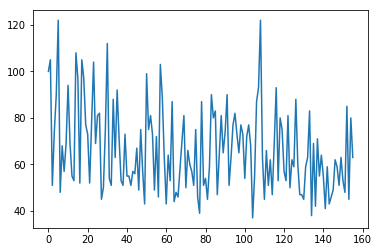

In [14]:
plt.plot(qAgent.training_rewards)

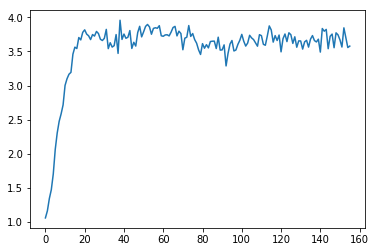

In [13]:
plt.plot(qAgent.training_loss)

In [100]:
qAgent.network.optimizer.zero_grad()
batch = qAgent.replayMemory.sample_batch(batch_size=32)
states, actions, rewards, next_states, mean_qvals, dones = [i for i in batch]
rewards_t = torch.FloatTensor(rewards)
actions_t = torch.LongTensor(np.array(actions)).reshape(-1,1)
rewards_t = torch.FloatTensor(rewards)
dones_t = torch.ByteTensor(dones)

qvals = torch.gather(torch.stack(mean_qvals), 1, actions_t).squeeze()
next_qvals_t = torch.max(qAgent.network.getQValues(next_states), dim=-1)[0].detach()
next_qvals_t[dones_t] = 0
expected_qvals = next_qvals_t + rewards_t
loss = nn.MSELoss()(qvals, expected_qvals)
loss

tensor(2.0493, grad_fn=<MseLossBackward>)

In [103]:
qvals

tensor([ 1.9312,  0.3944,  2.7097,  0.4170,  1.4932, -0.5354,  0.8132, -0.1335,
         3.0519,  0.7260,  2.6558, -0.7876, -0.9271,  0.3399,  3.5090, -0.0535,
         0.0186,  2.3184,  0.0052, -0.0501, -0.2216,  3.8629,  0.7800,  1.5467,
         2.2648,  1.8777,  3.4541, -0.6571,  0.0267, -0.4224, -0.3178,  1.1099],
       grad_fn=<SqueezeBackward0>)

In [101]:
loss.backward()

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [94]:
qAgent.network.optimizer.zero_grad()
batch = qAgent.replayMemory.sample_batch(batch_size=32)
loss = qAgent.calcLoss(batch)
loss.backward()

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [41]:
s = env.reset()
a, v = qAgent.getAction(s)

In [43]:
v

tensor([-0.0775,  0.0306], grad_fn=<ThAddBackward>)

In [77]:
r = torch.zeros((qAgent.time_steps, qAgent.n_actions))
r[0] = qAgent.I_0
E = np.sqrt(0.001) * np.random.randn(1000, 4)
s = env.reset()
state_est = np.zeros((1000, 4))
for t in range(1, 1000):
    state_est[t] = s + E[t]
    qvals = qnet.getQValues(s + E[t])
    for n in range(2):
        r[t, n] = r[t-1, n] + 0.001 * (qvals[n] + qAgent.I_0 + qAgent.K*r[t-1, n] - qAgent.B * \
            sum([r[t-1, m] for m in range(2) if n!=m]))

In [79]:
s_0 = env.reset()
ep_reward = 0
done = False
replay_buffer = replayMemory()
while done == False:
    action, qvals = qAgent.getAction(s_0)
    s_1, reward, done, _ = env.step(action)
    replay_buffer.append(s_0, action, reward, s_1.copy(), done)
    s_0 = s_1.copy()
    ep_reward += reward

In [80]:
batch = replay_buffer.sample_batch(batch_size=int(ep_reward))
states, actions, rewards, next_states, mean_qvals, dones = [i for i in batch]

In [81]:
qnet.getQValues(next_states)

tensor([[-0.0764, -0.7759],
        [-0.2589, -1.5391],
        [-0.1636, -1.1577],
        [-0.3625, -1.9216],
        [-0.5953, -2.6960],
        [-1.0108, -3.8971],
        [-0.4746, -2.3068],
        [-0.7248, -3.0903],
        [ 0.0029, -0.3921],
        [-0.8632, -3.4905]], grad_fn=<MmBackward>)

In [85]:
actions_t = torch.LongTensor(actions).reshape(-1, 1)
torch.gather(torch.stack(mean_qvals), 1, actions_t).squeeze()

tensor([ 0.0028, -0.1634, -0.0763, -0.2586, -0.4741, -0.8624, -0.3622, -0.5947,
         0.0741, -0.7240], grad_fn=<SqueezeBackward0>)

In [55]:
n = [qAgent.getAction(s) for s in next_states]

(tensor(0), tensor([-0.8227, -3.2594], grad_fn=<ThAddBackward>))

In [24]:
r = np.zeros((qAgent.time_steps, qAgent.n_actions))
E = np.sqrt(0.001) * np.random.randn(1000, 4)
s = env.reset()
state_est = np.zeros((1000, 4))
for t in range(1, 1000):
    state_est[t] = s + E[t]
    qvals = qnet.getQValues(s + E[t])
    for n in range(2):
        r[t,n] = qvals[n] + qAgent.I_0 + qAgent.K*r[t-1, n] - qAgent.B

RuntimeError: value cannot be converted to type float without overflow: -855035197632245607710428059366420643840.000000

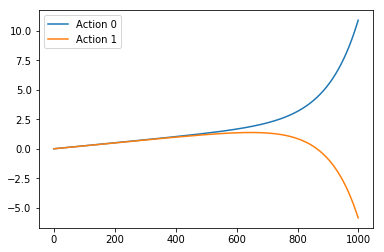

In [27]:
plt.figure()
r_n = torchToNumpy(r, device='cpu')
for i in range(2):
    plt.plot(r_n[:, i], label='Action ' + str(i))
    
plt.legend()
plt.show()

In [82]:
q_mean

array([-0.00346968,  0.02383885])

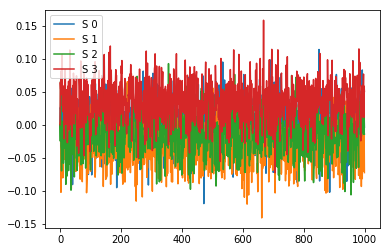

In [75]:
plt.figure()
for i in range(4):
    plt.plot(state_est[:, i], label='S ' + str(i))
    
plt.legend()
plt.show()

In [70]:
r[-1]

array([-52.32237979,  62.28297305])

## Results

## Conclusions